# Exploratory Data Anaysis

Before we begin with the *EDA* we need to read the *metadata*. If there is not or it is incomplete (as is our current case) we will create or add after the *EDA*.

We need highlight that the analysis the data we will be have an economics approach, but it can apply any approach.

In order to track the transformations that we apply to our data, each time we apply these transformation we will save all files and will do commit (*snapshoot*) using git. This useful by reasons of *reproducibility* 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Data Source:

* [Principles of Econometrics - Data](http://www.principlesofeconometrics.com)

* [wooldridge - Metadata](http://fmwww.bc.edu/ec-p/data/wooldridge/mroz.des)

  * It is a cross-sectional women's labor force participation data with 753 observations on 25 variables.
  * A short description of the meaning of the variables is above (metadata). But it is not enought.     
    e.g. $\text{lfp} = 1 \; \text{if the women belong labor force}, 0 \;\text{otherwise}$. This is our *target*, he variable we want to explain.

In [2]:
mroz = pd.read_csv('http://www.principlesofeconometrics.com/poe5/data/csv/mroz.csv')

In [3]:
print("(Records, Features):", mroz.shape)
print("Null: ", np.sum(np.sum(mroz.isnull())))

(Records, Features): (753, 25)
Null:  0


* We can see the structure of the data is *Homogeneous*, that is, all of records have the same schema. And also the data is *tabular*, since the schema is simple. The later can be test showing the data type. If it includes list type or array type this means the schema is complex.

In [4]:
print('Data types uniques: ', mroz.dtypes.unique())

Data types uniques:  [dtype('int64') dtype('float64')]


* Also we can see the data is cleanned (*there is not nulls*) so, we don't need to the stage of the *Cleasing Data*.

* This data can be taken as a *sample* or as the *population*. But almost always in a company, the data is the *population of customers*. So, the data will be considered as *population*. This *assumption* must point out in the metadata.

## Kids

**Metadata**:

* *kidslt6*: 
  * Answer to the question: *How many kids less that 6 year do you have?*
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 0 - 3, where 0 point out the women doesn't have kids and 3 point out the women have 3 kids.
  
* *kids618*: 
  * Answer to the question: *How many kids greater than 6 but less 18 year do you have?*
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 0 - 8, where 0 point out the women doesn't have kids and 8 point out the women have 8 kids.
  

In [5]:
print(mroz.groupby('lfp')[['kidsl6', 'kids618']].mean(), end='\n\n')

cross = mroz.groupby('lfp')[['kidsl6', 'kids618']].sum()
print(cross/cross.sum())

       kidsl6   kids618
lfp                    
0    0.366154  1.356923
1    0.140187  1.350467

       kidsl6   kids618
lfp                    
0    0.664804  0.432777
1    0.335196  0.567223


* We can see a women that belong to force labor has in average 0.22 less *kids (of age less than 6)* than a women that don't belong to force labor.

* Also, in average the $66\%$ of *kids (of age less than 6)*  have a mum doesn't belong to force labor.

* If a women has *kids (of age between 6 and 18 years)* seems is not relevant for the explanation of if a women belongs to force labor or not

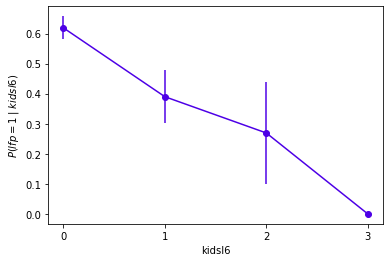

In [6]:
def plot_prob(feat:str):

    _, ax = plt.subplots()
    cross = mroz.groupby([feat])['lfp'].agg(['mean', lambda x :np.std(x)/np.sqrt(len(x))])
    cross.columns = ['MEAN', 'SE']
    color = (0.3, 0.0, 0.9)
    ax.errorbar(range(len(cross)), cross['MEAN'], 1.96*cross['SE'], color = color, fmt='-o')
    ax.set_xticks(range(len(cross))); ax.set_xticklabels(labels = cross.index)
    ax.set(xlabel = feat, ylabel  = rf'$P(lfp = 1 \;|\;{feat})$')
    return ax

plot_prob(feat = 'kidsl6');plt.show()

* We can see the probability a women belong to force labor decreases as the women had more kids (of the age less 6 years). If a women has 3 kids (of the age less 6 years) the probability belong to force labor is almost zero.

* The standar error plotted above increase as the women had more kids, but this is the effect of the size by each group (0, 1, 2, 3).

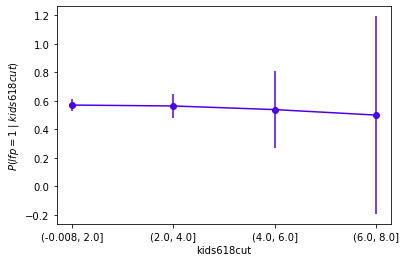

In [7]:
mroz['kids618cut'] = pd.cut(mroz['kids618'], bins = 4)
plot_prob(feat = 'kids618cut');plt.show()

* We can see the probability of a women belong to force labor don't change as the amount of kids increases.

* As above, the standar error plotted increase as the women had more kids, but this is the effect of the size of teh caterories 6, 7 and 8.



## Age

**Metadata**

* Age:

  * Answer to the question: *How old are you?*
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 33 - 60
  * Syntatic domain: years 

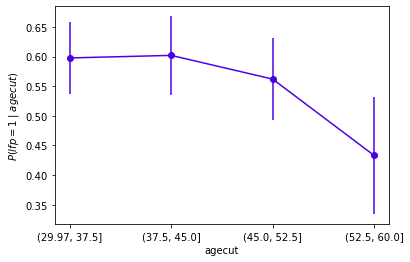

In [8]:
mroz['agecut'] = pd.cut(mroz.age, bins = 4)
plot_prob(feat = 'agecut');plt.show()

* As we hope, the probability of a women belong to force labor decrease as she is older. But if we compare this decresing with the effect of the kidsl6, the effect age on the probability of a women belong to force labor is less.

## Education

**Metadata**

* Education:
  * Data Type: Integer
  * Data classification: Categorical
  * Range: 4 - 17
  * Syntatic domain: years 


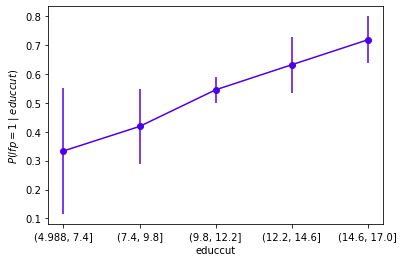

In [9]:
mroz['educcut'] = pd.cut(mroz.educ, bins = 5)
plot_prob(feat = 'educcut');plt.show()

## Join Effects

* *Age* and *Kids*
  
  The following analysis join the effects both Age and the Kids. 

Text(0.5, 0.98, "Women's Force Labor Supply Rate\n by Range of Educ Years")

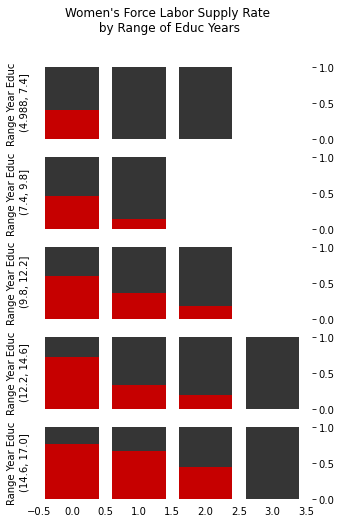

In [10]:
mroz_rates = mroz.pivot_table(index='kidsl6', columns='educcut', values='lfp')

fig, ax = plt.subplots(5, sharex="all", figsize = (5, 8))

_educcut = mroz_rates.columns
for (i, _educ) in enumerate(_educcut):
    _rr_vals = mroz_rates[_educ].values

    ax[i].bar(range(0, 4), _rr_vals, color="#c60000")
    ax[i].bar(range(0, 4), 1 - _rr_vals, bottom=_rr_vals, color="#353535")
    ax[i].set_ylabel(f'Range Year Educ \n{_educ}')
    for spine in ['left', 'right', 'top', 'bottom']:
        ax[i].spines[spine].set_visible(False)
    ax[i].yaxis.tick_right()
    ax[i].xaxis.set_ticks_position("none")

fig.suptitle("Women's Force Labor Supply Rate\n by Range of Educ Years")

* The plot showed above highlights what we already know, but this provides us a bit more information. For instance, the rate of the women's force labor supply increases if we join the two effects (*Kids* and *Educ*) than we would be analyzing the effects by separeted. 
  
  * *Join*: $0.76$ (*Educ* is in $(14.6, 17.0]$ and *Kid* is equal $0$) 
  * *Educ*: $0.7$ (*Educ* is in $(14.6, 17.0]$)
  * *Kids*: $0.6$ (*Kid* is equal $0$)

## Family and Husband

The effect of the women in the force labor supply on both *Family Income* and *Husband Wage*

**Metadata**
* Family Income
  * Data Type: Float
  * Syntatic domain: Dollar U.S.  
  * Semantic: Annual

In [11]:
def quantiles(feat:str):
    q = mroz.groupby('lfp')[feat].quantile([0, 0.25, 0.5, 0.75, 1]).unstack()
    return q.add_prefix('Quantile_')

quantiles('faminc')

,Quantile_0.0,Quantile_0.25,Quantile_0.5,Quantile_0.75,Quantile_1.0
lfp,,,,,
0,1500.0,14000.00,18965.0,26040.0,96000.0
1,2400.0,16286.25,21961.0,29793.0,91044.0


* As we can see the effects of the participation of women in the labor market on family income is positive for the families with low incomes.

* Due to the fact that the quantiles 0, 0.25, 0.5 and 0.75 have increased simultaneously we can infer the mean has increased as well. This mean a family can increses its income if the women can supply her the workforce.

**Metadata**

* Husband Wage
  * Data Type: Float
  * Syntatic domain: Dollar U.S.  
  * Semantic: Hour

In [12]:
quantiles('hwage')

,Quantile_0.0,Quantile_0.25,Quantile_0.5,Quantile_0.75,Quantile_1.0
lfp,,,,,
0,0.4121,4.73720,7.2274,9.375000,40.509
1,0.5128,4.82175,6.6831,8.837775,26.578


* The effects are inversed on husband wage. If a women supply in labor market, this produce negative effects on the husband wage for the husband that have high incomes, that is, it decrease. 

## Bootsraping Analysis

*P-values* using Bootstraping

* Assuming that the mean $μ_1$ is the average of the family income if the wife doesn't supply in labor market and Assuming that the mean $μ_0$ is the average of the family income if the wife does supply in labor market.

* So we have $Δ = μ_1 − μ_0$.

* We consider the one-sided hypotheses given by

$$H_0 : Δ = 0 \; \text{versus} \; H_1 : Δ > 0$$

* That is, our null hypothesis means there is not difference between the family incomes if the wife supply in labor market.

* Recall we only have a sample, this is used for bootstraping

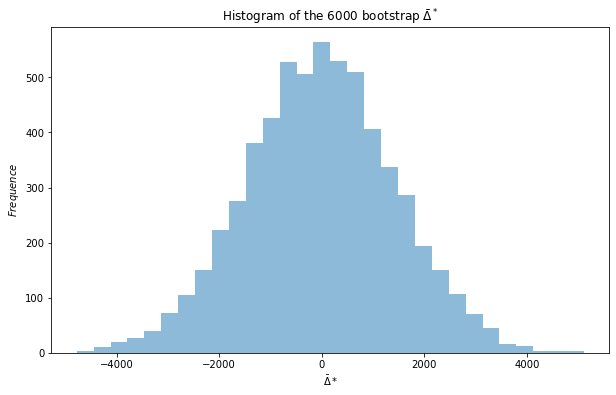

 > P-value:15.53%


In [296]:
# Δ = μ_1 − μ_0
# H0: Δ = 0, Ha: Δ > 0

def anaysis_boots(feat, B, data):
    cross = dict(data.groupby('lfp')[feat].mean())
    Δ = cross[1] - cross[0]

    data_grouped = data.groupby('lfp')

    def boots_sample():
        boots_means = {}
        for g, group_data in data_grouped:
            z = (group_data[feat] - Δ) if g == 1 else (group_data[feat])
            sample = np.random.choice(z, size= len(group_data[feat]), replace=True)
            boots_means[g] = np.mean(sample)
        return boots_means[1] - boots_means[0]

    boots_diff = np.array([boots_sample() for _ in range(B)])

    _, ax = plt.subplots(figsize = (10, 6))

    ax.hist(boots_diff, bins=30, density=False, alpha = 0.5)
    ax.set(xlabel = r'$\bar{Δ}*$', ylabel = '$Frequence$', title = f'Histogram of the {B} bootstrap '+r'$\bar{Δ}^*$')
    
    plt.show()
    p_value = sum(boots_diff>=Δ)/len(boots_diff)
    return ax, p_value, Δ

# Features
feat = 'faminc'
# Sampling by Bootstraping
B = 6000
# Take a sample
mroz_sample = mroz.groupby('lfp', group_keys=False).apply(lambda x:x.sample(100)) # random_state=123
data = mroz_sample.copy()

ax, p_value, Δ = anaysis_boots(feat, B, data);plt.show()
print(f' > P-value:{p_value:.2%}')

* The result of this experiment point out there is difference between the family incomes whether the wife supply in labor market or not.

* p-value indiques if we don't reject the null hypothesis, the probability of commit the error *type I* is $12.00\%$

* So, we can say the effect of the women on family income is enought to reject the $H_0$.

## What if we took other sample?

* The purpose of this apart is computing the mean of the p-values in order to see the behaviour of the p-values by several samples of the population and test the robutness if the p-value.

In [286]:
def anaysis_boots(feat, B, data):
    cross = dict(data.groupby('lfp')[feat].mean())
    Δ = cross[1] - cross[0]

    data_grouped = data.groupby('lfp')

    def boots_sample(): 
        boots_means = {}
        for g, group_data in data_grouped:
            z = (group_data[feat] - Δ) if g == 1 else (group_data[feat])
            sample = np.random.choice(z, size= len(group_data[feat]), replace=True)
            boots_means[g] = np.mean(sample)

        return boots_means[1] - boots_means[0]

    boots_diff = np.array([boots_sample() for _ in range(B)])
    p_value = sum(boots_diff>=Δ)/len(boots_diff)
    
    return p_value

In [287]:
feat = 'faminc'
B = 6000

def p_value_sampling():
    mroz_sample = mroz.groupby('lfp', group_keys=False).apply(lambda x:x.sample(100))
    data = mroz_sample.copy()
    p_value = anaysis_boots(feat, B, data)
    return p_value

In [288]:
p_values = (p_value_sampling() for _ in range(20))

In [289]:
sum(p_values)/20

0.12847499999999998

* The mean computed point out the robutness we hoped. 

* The mean of the p-values is closed at p-value computed by only sample.

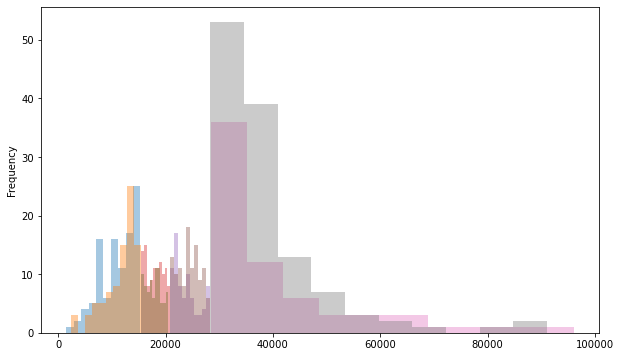

In [284]:
mroz['faminc_quantile'] = pd.cut(mroz.faminc, mroz.faminc.quantile([0, 0.25, 0.5, .75, 1]), include_lowest=True)

for _, group_by_quantile in mroz.groupby('faminc_quantile'):
    for _, group_by_lfp in group_by_quantile.groupby('lfp'):
        group_by_lfp.faminc.plot(kind = 'hist', alpha = 0.4, bins = 10, figsize = (10, 6))

## References

* Robert Hogg, Joseph McKean, Allen Craig - Introduction to Mathematical Statistics - Pages 311- 312.

* Chase Coleman, Spencer Lyon, and Jesse Perla - [QuanEcon](https://datascience.quantecon.org/applications/recidivism.html)

* Antonio Badia - SQL for Data Science. Data-Centric Systems and Applications.Springer Cham. Louisville, KY, USA. .July 2020 - Pages 165 - 166.